<a href="https://colab.research.google.com/github/tvaditya/intro_ds_and_ml/blob/main/%5BML7%5D_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

***Feature Engineering*** é usar dados, dentro do domínio do conhecimento, e criar *features* novas para o seu conjunto de dados. Quando você entende esse conceito e aplica corretamente as técnicas de engenharia, melhora ainda mais a capacidade de previsão do seu modelo de machine learning.


<center><img src="https://images.unsplash.com/photo-1504328345606-18bbc8c9d7d1?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1050&q=80"width="70%"></center>


> *The algorithms we used are very standard for Kagglers. […]  We spent most of our efforts in feature engineering  (Xavier Conort)* 


A verdade é que a engenharia de features demanda um conhecimento a respeito do seu problema. Por isso você deve investigar quais variáveis são importantes para o escopo identificado.

Vamos ver alguns exemplos de como criar novas features.

## Exemplo 1 - Mercado imobiliário de São Paulo

Normalmente, você vai pegar datasets que irão conter variáveis primárias, como é o caso dos dados deste exemplo.

Obviamente, poderíamos analisar e criar um modelo de machine learning para prever o preço de venda de um apartamento, apenas usando os dados originais que foram fornecidos.

No entanto, mesmo um bom modelo não irá conseguir capturar todas as nuances. Mesmo aquelas que seriam teoricamente simples, podem contribuir para melhorar o desempenho do seu algoritmo.

Os dados abaixo foram baixados diretamente [deste site](https://www.kaggle.com/argonalyst/sao-paulo-real-estate-sale-rent-april-2019), e foram disponibilizados publicamente por uma startup do setor imobiliário.

In [1]:
# importar os dados necessários
import pandas as pd
import numpy as np
import seaborn as sns
import geopy.distance

# importar dados para o dataframe
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/sao-paulo-properties-april-2019.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


Primeiramente, vou extrair apenas os apartamentos que foram colocados à venda. Como identifiquei que a coluna `Negotiation Type` contém apenas os valores `rent` e `sale`, basta fazer `'Negotiation Type'] == 'sale'`.

In [2]:
df_venda = df[df['Negotiation Type'] == 'sale'].copy()
df_venda.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552129,-46.692244
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.551613,-46.699106
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552590,-46.691104
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.553087,-46.697890


Uma métrica importante, que é levada em consideração na decisão de compra de imóvel, é o valor do metro quadrado.

Para conseguir esse número, basta dividir `Price` por `Size` e criar uma nova coluna.

In [3]:
df_venda['price_per_size'] = (df_venda['Price'] / df_venda['Size']).astype(int)

df_venda.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,price_per_size
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552129,-46.692244,9900
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.551613,-46.699106,12134
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594,10285
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552590,-46.691104,10838
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.553087,-46.697890,21428


Vamos imaginar que, especificamente para o seu projeto, a distância do imóvel para o Aeroporto de Guarulhos é uma característica relevante. Por que não criar uma coluna indicando essa distância, em relação a cada imóvel do dataset, e inserir essa variável no modelo?

Para calcular a distância entre duas coordenadas, vou usar o método `geopy.distance`

In [4]:
def calc_dist(coordinates):
    """Retorna a distância de um ponto até o GRU Airport"""

    gru_coordinates = (-23.4258, -46.4683)
    return geopy.distance.vincenty(gru_coordinates, coordinates).km

# criar coluna com a tupla (Latitude, Longitude)
df_venda["coordinates"] = list(zip(df_venda.Latitude, df_venda.Longitude))

# calcular a distância até GRU Airport
df_venda["distancia_gru"] = df_venda['coordinates'].apply(calc_dist)

# ver as 5 primeiras entradas
df_venda.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,price_per_size,coordinates,distancia_gru
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552129,-46.692244,9900,"(-23.552129, -46.692244)",26.815111
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.551613,-46.699106,12134,"(-23.551613, -46.699106)",27.386445
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594,10285,"(-23.547687, -46.692594)",26.592871
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552590,-46.691104,10838,"(-23.55259, -46.691104)",26.742577
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.553087,-46.697890,21428,"(-23.553087, -46.69789)",27.363215


## Exemplo 2 - Abrigo de animais abandonados

O Centro de animais de Austin, no Texas, provê abriga para mais de 16 mil animais por ano, além de outros serviços envolvendo proteção de animais - independente da raça, idade ou estado de saúde desses.

Tendo como principal objetivo "destinar todos os animais possíveis para um novo lar, seja por meio de adoção, assistência social ou grupos de resgate.

Apesar desse objetivo, não é possível conseguir um lar para todos esse animais, e muitos acabam sendo sacrificados. A meta do Austin Animal Center é conseguir que o desfecho positivo, ou seja a saída com vida desses animais, seja superior a 90% do total.

Neste projeto, iremos analisar as saídas com vida desses animais. Com essa análise, espera-se que sejamos capazes de identificar um padrão de adoção.

Mais que identificar um padrão, espera-se fazer previsões futuras em relação ao número de saídado Austin Animal Center, visando:

Planejar compras de insumos (remédios, comida, etc);
Contratação de funcionários e colaboradores; e
Fazer campanhas visando otimizar a adoção de animais.

Os dados foram disponibilizados pelo [Austin Animal Center](http://www.austintexas.gov/content/austin-animal-center) e podem ser baixados diretamente no [City of Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238).

O *dataset* usado neste *notebook* foi atualizado em 30 de abril de 2020 e contém **117K linhas** e **12 colunas**, onde  

In [5]:
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/shelter_animal_outcomes.csv"

# importar os dados para um DataFrame
df = pd.read_csv("https://github.com/carlosfab/escola-data-science/blob/master/datasets/shelter_animal_outcomes.csv?raw=true")

# converter a coluna DateTime para o formato conveniente
df.DateTime = pd.to_datetime(df.DateTime)

# ver as 5 primeiras entradas
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,2016-02-13 17:59:00,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,NaN,2014-03-18 11:47:00,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,2014-10-18 18:52:00,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black


In [6]:
df.DateTime.dt.weekday  # segunda = 0, domingo = 6

0         2
1         2
2         5
3         1
4         5
         ..
117411    3
117412    3
117413    3
117414    3
117415    3
Name: DateTime, Length: 117416, dtype: int64

In [7]:
# é final de semana?
df['weekend'] = np.where((df.DateTime.dt.dayofweek) < 5, 0, 1 )

# qual o mês?
df['month'] = df.DateTime.dt.month

In [ ]:
df.head()

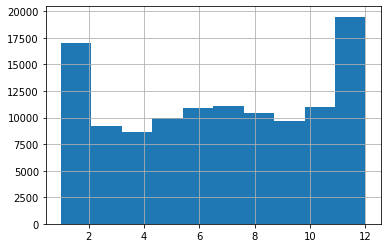

In [9]:
df.month.hist()